# TODOs
* Add Bayesian model
* Add strategy models

# Imports etc.

In [6]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
import scipy
gg.theme_set(gg.theme_bw)

plotnine.themes.theme_bw.theme_bw

In [7]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'

# Functions to simulate data

In [123]:
class RLAgent():
    
    def __init__(self, n_agents, params, init_Q=1/2, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.avail_actions = (0, 1)
        self.init_Q = init_Q
        self.Q = init_Q * np.ones((n_agents, len(self.avail_actions)))
        self.eps = eps
        self.prev_action = np.full(n_agents, np.nan)
        
    def take_action(self):
        """
        Take 1 action per agent, based on current trial Q-values.
        """
        
        ags = np.arange(self.n_agents)

        # Perseveration
        Q0 = self.Q[ags, 0]
        Q1 = self.Q[ags, 1]
        if not np.isnan(self.prev_action[0]):  # prev_action is np.nan on trial 0 only; only checking first element for simplicity
            Q0 += (1 - self.prev_action) * self.params['persev'].values  # action 0: subtract persev when repeating
            Q1 += self.prev_action * self.params['persev'].values   # action 1: add persev when repeating

        # Action selection
        lik = scipy.special.softmax(self.params['beta'].values * np.array([Q0, Q1]).T, axis=1)
        action = np.array([np.random.choice(self.avail_actions, p=lik[a]) for a in range(self.n_agents)])
        self.prev_action = action.copy()
        
#         lik = self.eps / 2 + (1 - self.eps) + lik  # squeeze between eps and 1-eps to avoid 0's and 1's
        
        return lik, action
    
    def update_Q(self, action, reward):
        """
        Update Q-values based on RL.
        """
        
        ags = np.arange(self.n_agents)
        
        rpe = (1 - self.Q[ags, action]) * reward  # received reward, updating chosen action
        nrpe = (0 - self.Q[ags, action]) * (1 - reward)  # received no reward, updating chosen action
        
        crpe = (0 - self.Q[ags, 1-action]) * reward  # received reward, updating unchosen action
        cnrpe = (1 - self.Q[ags, 1-action]) * (1 - reward)  # received no reard, updating unchosen action
        
        self.Q[ags, action] += self.params['alpha'].values * rpe + self.params['nalpha'].values * nrpe
        self.Q[ags, 1-action] += self.params['calpha'].values * crpe + self.params['cnalpha'].values * cnrpe


# Example use:
params = pd.DataFrame({
    'alpha': [0.8], 'nalpha': [0.1], 'calpha': [0.9], 'cnalpha': [0.1],
    'beta': [4], 'persev': [0.2], 'bias': [0]
})

agent = RLAgent(n_agents, params)
lik, action = agent.take_action()
print("action", action)
# correct, reward = task.present_reward(action, trial)
# print("reward", reward)
# agent.update_Q(action, reward)
# print("agent.Q", agent.Q)

action [0 1 1 0 0 0 0 1 1 0]


In [122]:
class PSTask():
    
    def __init__(self, p_cor, correct_actions, n_trials, block_lengths_lower, block_lengths_upper):
        """
        Must either provide block_lengths_lower and block_lengths_upper -> task will be created on the fly;
        or correct_actions -> provided task will be used.
        """
        
        self.p_cor = p_cor

        if len(correct_actions) > 0:
            self.correct_actions = correct_actions
            self.n_trials = len(correct_actions)
        elif block_lengths_lower: 
            self.block_lengths_lower = block_lengths_lower
            self.block_lengths_upper = block_lengths_upper
            self.n_trials = n_trials
            self.correct_actions = self.make_task()
        else:
            raise ValueError("You must provide either correct_actions or block_lengths_lower.")
        
    def make_task(self):
        """
        Currently just produces the same sequence of correct and incorrect boxes for each animal.
        In future, will read in animal data.
        """
        
        correct_actions = []
        block_lengths = np.random.randint(
            low=self.block_lengths_lower, high=self.block_lengths_upper, size=self.n_trials)

        for block_length, correct_side in zip(block_lengths, [0, 1] * self.n_trials):
            correct_actions += block_length * [correct_side]
        
        correct_actions = correct_actions[:self.n_trials]
        
        return correct_actions
        
    def get_chance_rewards(self, n_correct_choices):
        """
        Translate accuracy into rewards:
        Return '1' with probability self.p_cor and '0' with probability 1-self.p_cor, for each agent.
        """
        
        return np.array([np.random.choice((0, 1), p=(1-self.p_cor, self.p_cor)) for i in range(n_correct_choices)])

    def present_reward(self, action, trial):
        """
        Present reward (0, 1) for each agent in this trial, based on choices,
        by consulting the correct_box on the current trial.
        """
        
        correct = np.array(self.correct_actions[trial] == action).astype(int)
        reward = correct.copy()
        reward[reward == 1] = self.get_chance_rewards(sum(reward==1))
        
        return correct, reward
    
# Example use
n_trials = 725
p_cor = 0.75
block_lengths_lower = 40
block_lengths_upper = 41
n_agents = 10

task = PSTask(
    p_cor, n_trials=n_trials, block_lengths_lower=block_lengths_lower, block_lengths_upper=block_lengths_upper,
    correct_actions=[])
task.make_task()

task.get_chance_rewards(n_correct_choices=100)

action = np.zeros(n_agents)
trial = 0
task.present_reward(action, trial)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1]))

In [148]:
class BFAgent():
    
    def __init__(self, n_agents, params, p_r=0.5, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.p_reward = self.params['p_reward'].values
        self.p_switch = self.params['p_switch'].values
        self.beta = self.params['beta'].values
        self.persev = self.params['persev'].values
        self.p_r = p_r  # Bayesian posterior probability of selecting right (propagated through trials)
        self.p_right = p_right  # behavioral probability of selecting right (log-transformed and with perseverance bonus)
        self.p_noisy = eps
        self.avail_actions = (0, 1)
        self.prev_action = np.full(n_agents, np.nan)

    def take_action(self):
        """
        Take 1 action per agent, based on current trial likelihoods and priors.
        """
        
        action = np.array(
            [np.random.choice(self.avail_actions, p=self.p_right[a])
             for a in range(self.n_agents)])
        self.prev_action = action.copy()
        
        return self.p_right, action
        
    def get_likelihoods(self, action, reward):
        
        # p(r=r|choice=correct): Likelihood of outcome (reward 0 or 1) given choice was correct:
        #           |   reward==1   |   reward==0
        #           |---------------|-----------------
        # choice==1 | p_reward      | 1 - p_reward
        # choice==0 | p_noisy       | 1 - p_noisy

        lik_cor_rew1 = action * self.p_reward + (1 - action) * self.p_noisy
        lik_cor_rew0 = action * (1 - self.p_reward) + (1 - action) * (1 - self.p_noisy)
        self.lik_cor = reward * lik_cor_rew1 + (1 - reward) * lik_cor_rew0

        # p(r=r|choice=incorrect): Likelihood of outcome (reward 0 or 1) given choice was incorrect:
        #           |   reward==1   |   reward==0
        #           |---------------|-----------------
        # choice==1 | p_noisy       | 1 - p_noisy
        # choice==0 | p_reward      | 1 - p_reward

        lik_inc_rew1 = action * self.p_noisy + (1 - action) * self.p_reward
        lik_inc_rew0 = action * (1 - self.p_noisy) + (1 - action) * (1 - self.p_reward)
        self.lik_inc = reward * lik_inc_rew1 + (1 - reward) * lik_inc_rew0

        return lik_cor, lik_inc
        
    def update_priors(self, action, reward):
        
        # Apply Bayes rule: Posterior prob. that right action is correct, based on likelihood (i.e., received feedback)
        self.p_r = self.lik_cor * self.p_r / (self.lik_cor * self.p_r + self.lik_inc * (1 - self.p_r))

        # Take into account that a switch might occur
        self.p_r = (1 - self.p_switch) * self.p_r + self.p_switch * (1 - self.p_r)

        # Add perseverance bonus
        if not np.isnan(self.prev_action[0]):  # prev_action is np.nan on trial 0 only; only checking first element for simplicity
            persev_bonus = 2 * self.prev_action - 1  # -1 for choice==0 (left) and +1 for choice==1 (right)
            scaled_persev_bonus = persev_bonus * self.persev
            p_right0 = self.p_r + scaled_persev_bonus
        else:
            p_right0 = self.p_r.copy()

        # Log-transform probabilities
        self.p_right = scipy.special.softmax(-self.beta * np.array([p_right0, (1 - p_right0)]).T, axis=1)
        self.p_right = 0.0001 + 0.9998 * self.p_right  # make 0.0001 < p_right < 0.9999

        # p_r is the actual probability of right, which is the prior for the next trial
        # p_right is p_r after adding perseveration and log-transform, used to select actions
        return self.p_r, self.p_right, p_right0
        
    
# Example use
params = pd.DataFrame({
    'p_reward': [0.75], 'p_switch': [0.05], 'beta': [1], 'persev': [0.1],
})
n_agents = 100
agent = BFAgent(n_agents, params)

action = np.ones(n_agents)
reward = np.ones(n_agents)

lik_cor, lik_inc = agent.get_likelihoods(action=action, reward=reward)
lik_cor, lik_inc

p_r, p_right, p_right0 = agent.update_priors(action=action, reward=reward)
p_r, p_right, p_right0

lik, action = agent.take_action()
action

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1])

In [160]:
def simulate_dataset(task_args, agent_args, model_class, suff=''):
    
    actions = []
    liks = []
    rewards = []
    corrects = []

    # Get task and agent
    task = PSTask(task_args['p_cor'], n_trials=task_args['n_trials'],
                  block_lengths_lower=task_args['block_lengths_lower'], block_lengths_upper=task_args['block_lengths_upper'],
                  correct_actions=task_args['correct_actions'])
    if model_class == 'BF':
        agent = BFAgent(agent_args['n_agents'], agent_args['params'])
    elif model_class == 'RL':
        agent = RLAgent(agent_args['n_agents'], agent_args['params'])

    # Play the game, save data
    for trial in range(n_trials):

        lik, action = agent.take_action()
        correct, reward = task.present_reward(action, trial)
        if model_class == 'BF':
            agent.get_likelihoods(action, reward)
            agent.update_priors(action, reward)
        elif model_class == 'RL':
            agent.update_Q(action, reward)

        actions += [action]
        liks += [lik]
        rewards += [reward]
        corrects += [correct]

    # Format data
    data = pd.DataFrame(
            {'action' + suff: actions, 'lik' + suff: liks,
             'reward' + suff: rewards, 'correct' + suff: corrects, 'correct_action': task.correct_actions})
    data = data.reset_index()
    data = data.rename(columns={'index': 'trial'})

    data['mean_reward'] = np.mean(np.array(list(data['reward' + suff])), axis=1)
    data['mean_correct'] = np.mean(np.array(list(data['correct' + suff])), axis=1)
    data['block'] = np.append([0], np.cumsum(np.abs(np.diff(task.correct_actions))))

    return data

# Example use
task_args = {
    'p_cor': 0.75, 'correct_actions': [], 'n_trials': n_trials,
    'block_lengths_lower': block_lengths_lower, 'block_lengths_upper': block_lengths_upper
}
agent_args = {
    'n_agents': n_agents, 'params': params,
}

data = simulate_dataset(task_args, agent_args, 'BF')
data

,trial,action,lik,reward,correct,correct_action,mean_reward,mean_correct,block
0,0,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[[0.2890976182557136, 0.7109023817442864], [0....","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",0,0.18,0.25,0
1,1,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, ...","[[0.7502055576292073, 0.2497944423707927], [0....","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, ...","[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, ...",0,0.45,0.62,0
2,2,"[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, ...","[[0.7502098168839025, 0.2497901831160974], [0....","[0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, ...","[0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, ...",0,0.51,0.65,0
3,3,"[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, ...","[[0.6629519368436473, 0.3370480631563527], [0....","[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...",0,0.57,0.68,0
4,4,"[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[[0.6616707916194371, 0.33832920838056285], [0...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",0,0.52,0.70,0
...,...,...,...,...,...,...,...,...,...
720,720,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, ...","[[0.2497901830594636, 0.7502098169405365], [0....","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",0,0.25,0.32,18
721,721,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, ...","[[0.31286015520742405, 0.687139844792576], [0....","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",0,0.40,0.50,18
722,722,"[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[[0.45466337724726197, 0.5453366227527382], [0...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...","[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...",0,0.56,0.64,18
723,723,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[0.7502057176394287, 0.2497942823605713], [0....","[0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",0,0.43,0.61,18


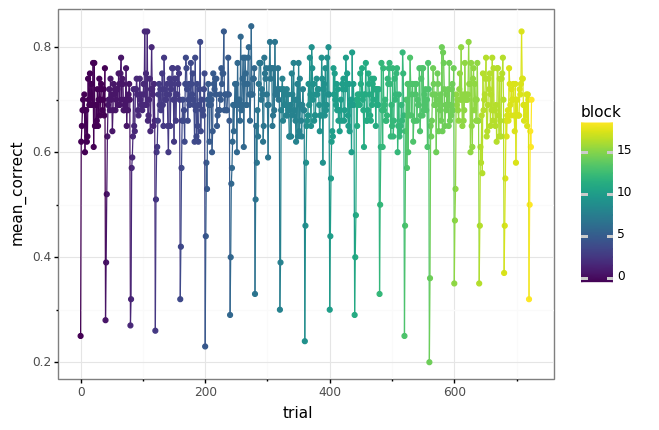

<ggplot: (-9223371901567518078)>

In [161]:
(gg.ggplot(data, gg.aes('trial', 'mean_correct', color='block'))
 + gg.geom_point()
 + gg.geom_line()
)

# Putting it all together

## Get true mouse data for IDs and action sequences

In [151]:
fullID_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_AnimalID.csv')).T.values.flatten()
fullID_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_AnimalID.csv')).T.values.flatten()
fullIDs = np.concatenate([fullID_j, fullID_a])
animals = [int(str(fullID)[:-5]) for fullID in fullIDs]
ages = [int(str(fullID)[-5:-2]) for fullID in fullIDs]
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
true_dat

,Unnamed: 0,action,reward,correct,correct_action,trial,block,fullID,animal,age,gender,agegroup,rew_1ago,rew_2ago,switch,block_length,block_trial,trials2switch,session,rew_12ago
0,0,0,0,0,1,0,0,1404012,14,40,Male,Juvenile,NaN,NaN,NaN,12.0,0.0,0.0,0.0,nn
1,1,0,0,0,1,1,0,1404012,14,40,Male,Juvenile,0.0,NaN,0.0,12.0,1.0,1.0,0.0,0n
2,2,1,1,1,1,2,0,1404012,14,40,Male,Juvenile,0.0,0.0,1.0,12.0,2.0,2.0,0.0,00
3,3,1,1,1,1,3,0,1404012,14,40,Male,Juvenile,1.0,0.0,0.0,12.0,3.0,3.0,0.0,10
4,4,1,1,1,1,4,0,1404012,14,40,Male,Juvenile,1.0,1.0,0.0,12.0,4.0,4.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319720,720,1,1,1,1,720,30,1309021,13,90,Female,Adult,0.0,0.0,1.0,20.0,16.0,16.0,18.0,00
319721,721,1,1,1,1,721,30,1309021,13,90,Female,Adult,1.0,0.0,0.0,20.0,17.0,-3.0,18.0,10
319722,722,1,1,1,1,722,30,1309021,13,90,Female,Adult,1.0,1.0,0.0,20.0,18.0,-2.0,18.0,11
319723,723,1,1,1,1,723,30,1309021,13,90,Female,Adult,1.0,1.0,0.0,20.0,19.0,-1.0,18.0,11


## Get fitted params

In [153]:
fitted_params = pd.DataFrame()
modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f)]
for modelname in modelnames:
    model_params = pd.read_csv(os.path.join(fitted_param_dir, modelname))
    model_params['model'] = modelname.split('_')[1]
    fitted_params = fitted_params.append(model_params, sort=False)
fitted_params

,beta,persev,p_noisy,p_switch,p_reward,sID,slope_variable,fullID,animal,PreciseYrs,...,session,age_z,T1,PDS,model,bias,alpha,nalpha,calpha,cnalpha
0,2.198803,0.511863,0.00001,0.050816,0.948604,1404012,age_z,1404012,14,40,...,0,-1.052255,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
1,1.681370,0.530221,0.00001,0.050816,0.965751,1404112,age_z,1404112,14,41,...,1,-0.997610,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
2,1.625380,0.472071,0.00001,0.050816,0.983376,1404212,age_z,1404212,14,42,...,2,-0.942965,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
3,7.095221,0.436275,0.00001,0.050816,0.993359,1404312,age_z,1404312,14,43,...,3,-0.888320,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
4,2.570709,0.360621,0.00001,0.050816,0.963808,1404412,age_z,1404412,14,44,...,4,-0.833675,0,0,Bbpr,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,4.244474,0.000000,NaN,NaN,NaN,1308521,age_z,1308521,13,85,...,11,1.406765,0,0,RLab,0.0,0.816118,0.816118,0.0,0.0
436,5.005828,0.000000,NaN,NaN,NaN,1308621,age_z,1308621,13,86,...,12,1.461410,0,0,RLab,0.0,0.757376,0.757376,0.0,0.0
437,3.570965,0.000000,NaN,NaN,NaN,1308821,age_z,1308821,13,88,...,13,1.570700,0,0,RLab,0.0,0.654044,0.654044,0.0,0.0
438,5.105522,0.000000,NaN,NaN,NaN,1308921,age_z,1308921,13,89,...,14,1.625345,0,0,RLab,0.0,0.794029,0.794029,0.0,0.0


### Plot fitted params

In [154]:
fitted_params_ = fitted_params.copy()
fitted_params_['beta'] /= 20
fitted_params_long = fitted_params_.melt(
    id_vars=['sID', 'slope_variable', 'fullID', 'animal', 'PreciseYrs', 'Gender', 'treatment',
             'session', 'age_z', 'T1', 'PDS', 'model'],
    value_name='param_value', var_name='param'
)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 20240 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 20240 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\fitted_params.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 20240 rows containing non-finite values.
  data = self.stat.compute_layer

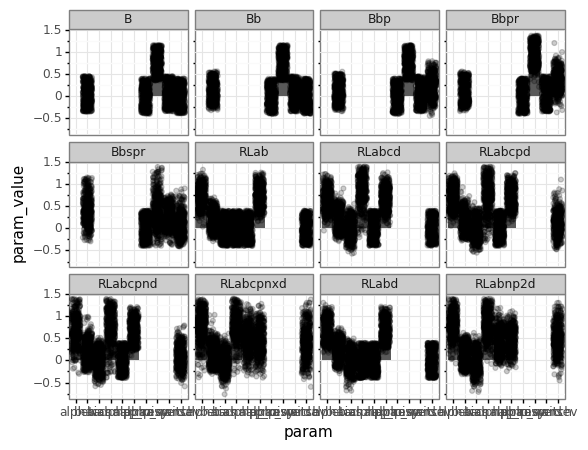

In [155]:
g = (gg.ggplot(fitted_params_long, gg.aes('param', 'param_value'))
 + gg.stat_summary(geom='bar')
 + gg.geom_point(position='jitter', alpha=0.2)
 + gg.facet_wrap('~ model')
)
g.draw()
g.save(os.path.join(plot_dir, 'fitted_params.png'))

## Simulate all RL models

In [ ]:
n_agents = 10
model_names = [modelname.split('_')[1] for modelname in modelnames]
print(model_names)

for model_name in model_names:
    print('Working on {}...'.format(model_name))
    sim_data = pd.DataFrame()
    
    if 'B' in model_name:
        param_names = ['beta', 'persev', 'p_switch', 'p_reward']
        model_class = 'BF'
    elif 'RL' in model_name:
        param_names = ['alpha', 'nalpha', 'calpha', 'cnalpha', 'beta', 'persev', 'bias']
        model_class = 'RL'

    for animal, age, fullID in zip(animals, ages, fullIDs):
        if (animal != 23) and (age != 43):  # Error in the Juvi_AnimalID.csv - rerunning fitted_params with fixed one

            # Get task for this mouse
            true_sub = true_dat.loc[(true_dat.age == age) & (true_dat.animal == animal)]
            n_trials = len(np.unique(true_sub.trial))
            correct_actions = true_sub.correct_action.values

            # Get params
            params = fitted_params.loc[
                (fitted_params.PreciseYrs == age) & (fitted_params.animal == animal) & (fitted_params.model == model_name),
                param_names]
            task_args = {
                'p_cor': 0.75, 'correct_actions': correct_actions, 'n_trials': 0,
                'block_lengths_lower': False, 'block_lengths_upper': False
            }
            agent_args = {
                'n_agents': n_agents, 'params': params,
            }

            sub_data = simulate_dataset(task_args, agent_args, model_class=model_class, suff='all')
            sub_data['session'] = true_sub.session
            sub_data['animal'] = animal
            sub_data['age'] = age
            sub_data['fullID'] = fullID
            sub_data['model'] = model_name

            sim_data = sim_data.append(sub_data)
    
    save_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
    print("Saving sim_data ({}) to {}...".format(sim_data.shape, save_dir))
    sim_data.to_csv(save_dir, index=False)

Bbpr ['Bbpr', 'Bbp', 'Bbspr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']
Saving sim_data ((290725, 14)) to C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/simulations/simulated_mice_Bbpr_nagents100.csv...
Bbp ['Bbpr', 'Bbp', 'Bbspr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']
Saving sim_data ((290725, 14)) to C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/simulations/simulated_mice_Bbp_nagents100.csv...
Bbspr ['Bbpr', 'Bbp', 'Bbspr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']
Saving sim_data ((290725, 14)) to C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/simulations/simulated_mice_Bbspr_nagents100.csv...
Bb ['Bbpr', 'Bbp', 'Bbspr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']
Saving sim_data ((290725, 14)) to C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/simulations/simulated_mice_Bb_nagent

### Basic check that simulated behavior looks reasonable

In [13]:
gg.options.figure_size = (10, 10)
(gg.ggplot(sim_data, gg.aes('trial', 'mean_correct', color='gender'))
 + gg.stat_summary()
)

PlotnineError: "Could not evaluate the 'color' mapping: 'gender' (original error: name 'gender' is not defined)"